### Versao vinda da 10

In [7]:
import random
import numpy as np
import pandas as pd

# Constantes de Estabilidade
KM = 12  # Altura do metacentro acima da quilha em metros
KG = 8   # Altura inicial do centro de gravidade em metros
MIN_GM = 0.5  # Mínimo valor permitido para GM em metros
MAX_HEEL = 5  # Máximo valor permitido para inclinação lateral em graus
MAX_TRIM = 2  # Máximo valor permitido para inclinação longitudinal em graus
CAPACIDADE_MAXIMA = 550  # Capacidade máxima da balsa em toneladas

# Função para calcular a estabilidade
def calcular_estabilidade(containers):
    peso_total = sum(peso for peso, _, _, _ in containers)
    centro_gravidade_z = sum(peso * z for peso, _, _, z in containers) / peso_total
    GM = KM - centro_gravidade_z
    heel = sum(peso * x for peso, x, _, _ in containers) / (peso_total * 10)
    trim = sum(peso * y for peso, _, y, _ in containers) / (peso_total * 10)
    
    estavel = GM >= MIN_GM and abs(heel) <= MAX_HEEL and abs(trim) <= MAX_TRIM
    return estavel, GM, heel, trim

# Função modificada para incluir cálculo de estabilidade
def preencher_porto(df_cromossomo):
    porto = np.zeros((2, 5, 3), dtype=int)
    balsa = np.zeros((3, 4, 3), dtype=int)
    porto_preenchido = np.ones((2, 5, 3), dtype=int)
    cal_movimentos = 0
    
    ordem_inicial = []
    df_cromossomo = df_cromossomo.sort_values(by='Posição Inicial')
    for _, linha in df_cromossomo.iterrows():
        ordem_inicial.append(linha['Container'])
    idx = 0
    for andar in range(2):
        for x in range(5):
            for y in range(3):
                if idx < 30:
                    porto[andar, x, y] = ordem_inicial[idx]
                    idx += 1
    
    df_cromossomo = df_cromossomo.sort_values(by='Ordem de Movimentação')
    containers = []
    min_GM = float('inf')
    
    errou = 0
    pode_mover = True
    for _, linha in df_cromossomo.iterrows():
        container = linha['Container']
        pos_inicial = linha['Posição Inicial']
        pos_final = linha['Posição Final']
        
        andar_ini, x_ini, y_ini = pos_inicial // 15, (pos_inicial % 15) // 3, (pos_inicial % 15) % 3
        andar_fin, x_fin, y_fin = pos_final // 12, (pos_final % 12) // 3, (pos_final % 12) % 3
        
        

        if (errou == 0):
            if andar_ini < 1 and porto_preenchido[andar_ini + 1, x_ini, y_ini] == 1:
                errou = 1
                pode_mover = False
            if andar_fin > 0 and balsa[andar_fin - 1, x_fin, y_fin] == 0:
                errou = 1
                pode_mover = False
            if balsa[andar_fin, x_fin, y_fin] == 1:
                errou = 1
                pode_mover = False
            
            if andar_fin > 0:
                for z in range(andar_fin):
                    if balsa[z, x_fin, y_fin] == 0:
                        errou = 1
                        pode_mover = False
                    
            if pode_mover:
                porto_preenchido[andar_ini, x_ini, y_ini] = 0
                balsa[andar_fin, x_fin, y_fin] = 1
                cal_movimentos += 2
                cal_movimentos += 0 if x_ini == x_fin else 1
                cal_movimentos += 0 if y_ini == y_fin else 1
                
                peso_container = 10
                containers.append((peso_container, x_fin, y_fin, andar_fin * 2.6))

                estavel, GM, heel, trim = calcular_estabilidade(containers)
                min_GM = min(min_GM, GM)
                if not estavel:
                    errou = 1
                    pode_mover = False
            else:
                cal_movimentos += 1000
        else:
            cal_movimentos += 1000

    return cal_movimentos, min_GM

# Funções do algoritmo genético
def gerar_cromossomo():
    cromossomo = []
    
    # Gera posições iniciais (0-29)
    posicoes_iniciais = list(range(30))
    random.shuffle(posicoes_iniciais)
    cromossomo.extend(posicoes_iniciais)
    
    posicoes_finais = list(range(36))
    random.shuffle(posicoes_finais)
    posicoes_finais = posicoes_finais[:30]
    cromossomo.extend(posicoes_finais)
    
    # Gera ordem de movimentação (0-29)
    ordem_movimentacao = list(range(30))
    random.shuffle(ordem_movimentacao)
    cromossomo.extend(ordem_movimentacao)
    
    return cromossomo

def cromossomo_para_dataframe(cromossomo):
    container = list(range(30))
    posicao_inicial = cromossomo[:30]
    posicao_final = cromossomo[30:60]
    ordem_movimentacao = cromossomo[60:90]
    
    df = pd.DataFrame({
        'Container': container,
        'Posição Inicial': posicao_inicial,
        'Posição Final': posicao_final,
        'Ordem de Movimentação': ordem_movimentacao
    })
        
    df = df.sort_values(by='Ordem de Movimentação')
    
    return df

def inicializar_populacao(tamanho_populacao):
    populacao = []
    for _ in range(tamanho_populacao):
        cromossomo = gerar_cromossomo()
        populacao.append(cromossomo)
    return populacao

def verifica_repetidos(cromossomo):
    intervalos = [
        (0, 29),
        (30, 59),
        (60, 89)
    ]
    
    for intervalo in intervalos:
        valores = cromossomo[intervalo[0]:intervalo[1]+1]
        if len(valores) != len(set(valores)):
            return True
    
    return False

def selecao_roleta(populacao, fitness):
    soma_fitness = sum(fitness)
    pick = random.uniform(0, soma_fitness)
    atual = 0
    for cromossomo, fit in zip(populacao, fitness):
        atual += fit
        if atual >= pick:
            return cromossomo

def cruzamento_pmx(pai1, pai2, inicio, fim):
    tamanho = fim - inicio + 1
    filho1 = pai1[:inicio] + [-1] * tamanho + pai1[fim+1:]
    filho2 = pai2[:inicio] + [-1] * tamanho + pai2[fim+1:]
    
    mapeamento1 = pai1[inicio:fim+1]
    mapeamento2 = pai2[inicio:fim+1]
    
    # Copiar o segmento
    filho1[inicio:fim+1] = mapeamento2
    filho2[inicio:fim+1] = mapeamento1
    
    # Resolver conflitos para filho1
    for i in range(inicio):
        if filho1[i] in mapeamento2:
            idx = mapeamento2.index(filho1[i])
            while mapeamento1[idx] in mapeamento2:
                idx = mapeamento2.index(mapeamento1[idx])
            filho1[i] = mapeamento1[idx]
    
    for i in range(fim+1, len(pai1)):
        if filho1[i] in mapeamento2:
            idx = mapeamento2.index(filho1[i])
            while mapeamento1[idx] in mapeamento2:
                idx = mapeamento2.index(mapeamento1[idx])
            filho1[i] = mapeamento1[idx]
    
    # Resolver conflitos para filho2
    for i in range(inicio):
        if filho2[i] in mapeamento1:
            idx = mapeamento1.index(filho2[i])
            while mapeamento2[idx] in mapeamento1:
                idx = mapeamento1.index(mapeamento2[idx])
            filho2[i] = mapeamento2[idx]
    
    for i in range(fim+1, len(pai2)):
        if filho2[i] in mapeamento1:
            idx = mapeamento1.index(filho2[i])
            while mapeamento2[idx] in mapeamento1:
                idx = mapeamento1.index(mapeamento2[idx])
            filho2[i] = mapeamento2[idx]
    
    return filho1, filho2

def cruzamento(pai, mae):
    filho1, filho2 = pai[:], mae[:]
    
    ponto_corte1 = random.randint(0, 29)
    ponto_corte2 = random.randint(0, 29)
    inicio, fim = min(ponto_corte1, ponto_corte2), max(ponto_corte1, ponto_corte2)
    filho1[:30], filho2[:30] = cruzamento_pmx(pai[:30], mae[:30], inicio, fim)
    
    ponto_corte1 = random.randint(30, 59)
    ponto_corte2 = random.randint(30, 59)
    inicio, fim = min(ponto_corte1, ponto_corte2) - 30, max(ponto_corte1, ponto_corte2) - 30
    filho1[30:60], filho2[30:60] = cruzamento_pmx(pai[30:60], mae[30:60], inicio, fim)
    
    ponto_corte1 = random.randint(60, 89)
    ponto_corte2 = random.randint(60, 89)
    inicio, fim = min(ponto_corte1, ponto_corte2) - 60, max(ponto_corte1, ponto_corte2) - 60
    filho1[60:90], filho2[60:90] = cruzamento_pmx(pai[60:90], mae[60:90], inicio, fim)
    
    return filho1, filho2

def mutacao(cromossomo, taxa_mutacao=0.01):
    if random.random() < taxa_mutacao:
        part = random.randint(0, 2)
        idx1, idx2 = random.sample(range(30), 2)
        if part == 0:
            cromossomo[idx1], cromossomo[idx2] = cromossomo[idx2], cromossomo[idx1]
        elif part == 1:
            cromossomo[30+idx1], cromossomo[30+idx2] = cromossomo[30+idx2], cromossomo[30+idx1]
        else:
            cromossomo[60+idx1], cromossomo[60+idx2] = cromossomo[60+idx2], cromossomo[60+idx1]
    return cromossomo

def algoritmo_genetico(tamanho_populacao, taxa_mutacao, alfa):
    populacao = inicializar_populacao(tamanho_populacao)
    fitness = []

    for cromossomo in populacao:
        cal_movimentos, min_GM = preencher_porto(cromossomo_para_dataframe(cromossomo))
        fit = cal_movimentos + alfa * (1 / min_GM)
        fitness.append(fit)
    
    geracao = 0
    sem_melhoria = 0
    melhor_fit = min(fitness)
    
    while sem_melhoria < 100 :
        geracao += 1
        nova_populacao = []
        while len(nova_populacao) < tamanho_populacao:
            pai = selecao_roleta(populacao, fitness)
            mae = selecao_roleta(populacao, fitness)
            
            filho1, filho2 = cruzamento(pai, mae)
            filho1 = mutacao(filho1, taxa_mutacao)
            filho2 = mutacao(filho2, taxa_mutacao)
            
            nova_populacao.append(filho1)
            nova_populacao.append(filho2)
        
        populacao.extend(nova_populacao)
        fitness = []

        for cromossomo in populacao:
            cal_movimentos, min_GM = preencher_porto(cromossomo_para_dataframe(cromossomo))
            fit = cal_movimentos + alfa * (1 / min_GM)
            fitness.append(fit)
        
        populacao_ordenada = sorted(zip(populacao, fitness), key=lambda x: x[1])
        
        melhor_5_porcento = int(tamanho_populacao * 0.05)
        nova_metade = tamanho_populacao - melhor_5_porcento
        
        populacao = [cromossomo for cromossomo, _ in populacao_ordenada[:melhor_5_porcento]] + [cromossomo for cromossomo, _ in populacao_ordenada[melhor_5_porcento:melhor_5_porcento+nova_metade]]
        fitness = [fit for _, fit in populacao_ordenada[:melhor_5_porcento]] + [fit for _, fit in populacao_ordenada[melhor_5_porcento:melhor_5_porcento+nova_metade]]
        
        nova_melhor_fit = min(fitness)
        print(f"Geração {geracao}: Melhor fitness = {nova_melhor_fit} Repetiu = {sem_melhoria}")

        if nova_melhor_fit < melhor_fit:
            melhor_fit = nova_melhor_fit
            sem_melhoria = 0
        else:
            sem_melhoria += 1
    
    melhor_cromossomo = populacao[fitness.index(min(fitness))]
    return melhor_cromossomo, min(fitness)

# Configurações
tamanho_populacao = 100
taxa_mutacao = 0.1
alfa = 5  # Ajuste conforme necessário

melhor_cromossomo, melhor_fit = algoritmo_genetico(tamanho_populacao, taxa_mutacao, alfa)
print(f"Melhor cromossomo encontrado: {melhor_cromossomo}")
print(f"Melhor fitness: {melhor_fit}")


Geração 1: Melhor fitness = 28006.467289719625 Repetiu = 0
Geração 2: Melhor fitness = 28006.467289719625 Repetiu = 1
Geração 3: Melhor fitness = 27010.416666666668 Repetiu = 2
Geração 4: Melhor fitness = 27010.416666666668 Repetiu = 0
Geração 5: Melhor fitness = 27010.416666666668 Repetiu = 1
Geração 6: Melhor fitness = 27010.416666666668 Repetiu = 2
Geração 7: Melhor fitness = 27010.416666666668 Repetiu = 3
Geração 8: Melhor fitness = 27010.416666666668 Repetiu = 4
Geração 9: Melhor fitness = 27010.416666666668 Repetiu = 5
Geração 10: Melhor fitness = 27009.416666666668 Repetiu = 6
Geração 11: Melhor fitness = 27009.416666666668 Repetiu = 0
Geração 12: Melhor fitness = 26015.467289719625 Repetiu = 1


#### Verifica se ha numeros repetidos


In [10]:
def verifica_repetidos(cromossomo):
    intervalos = [
        (0, 29),
        (30, 59),
        (60, 89)
    ]
    
    for intervalo in intervalos:
        valores = cromossomo[intervalo[0]:intervalo[1]+1]
        if len(valores) != len(set(valores)):
            return True
    
    return False

if verifica_repetidos(melhor_cromossomo):
    print("Valores repetidos encontrados!")
else:
    print("Não há valores repetidos.")

df_cromossomo = cromossomo_para_dataframe(melhor_cromossomo)
print("DataFrame do Cromossomo:")
print(df_cromossomo)


Não há valores repetidos.
DataFrame do Cromossomo:
    Container  Posição Inicial  Posição Final  Ordem de Movimentação
7           7               15              0                      0
8           8               27              9                      1
10         10               23              8                      2
20         20               21             20                      3
21         21               20             11                      4
23         23               26             23                      5
4           4               17              2                      6
5           5               12             12                      7
15         15               16              1                      8
29         29               25             10                      9
13         13               18             24                     10
2           2                2             14                     11
12         12                0             13       

### Simular Melhor cromomossomo

In [11]:
def Simular_preencher_porto(df_cromossomo):
    # Inicializar o porto e balsa
    porto = np.zeros((2, 5, 3), dtype=int)
    balsa = np.zeros((3, 4, 3), dtype=int)
    porto_preenchido = np.ones((2, 5, 3), dtype=int)
    cal_movimentos = 0
    
    # Preencher o porto com os dados do cromossomo
    ordem_inicial = []
    ordem_final = []

    df_cromossomo = df_cromossomo.sort_values(by='Posição Inicial')
    for _, linha in df_cromossomo.iterrows():
        ordem_inicial.append(linha['Container'])
    idx = 0
    for andar in range(2):
        for x in range(5):
            for y in range(3):
                if idx < 30:
                    porto[andar, x, y] = ordem_inicial[idx]
                    idx += 1
    
    df_cromossomo = df_cromossomo.sort_values(by='Ordem de Movimentação')
    containers = []
    
    # Realizar movimentações
    for _, linha in df_cromossomo.iterrows():
        container = linha['Container']
        a_pos_inicial = linha['Posição Inicial']
        a_pos_final = linha['Posição Final']
        pos_inicial = linha['Posição Inicial'] 
        pos_final = linha['Posição Final'] 
        
        andar_ini, x_ini, y_ini = pos_inicial // 15, (pos_inicial % 15) // 3, (pos_inicial % 15) % 3
        andar_fin, x_fin, y_fin = pos_final // 12, (pos_final % 12) // 3, (pos_final % 12) % 3
        
        errou = 0
        pode_mover = True

        if (errou==0):
            
            # Verificar se podemos remover do porto preenchido
            if andar_ini < 1:
                if porto_preenchido[andar_ini + 1, x_ini, y_ini] == 1:
                    errou =1
                    pode_mover = False
            
            # Verificar se podemos adicionar à balsa
            if andar_fin > 0:
                if balsa[andar_fin - 1, x_fin, y_fin] == 0:
                    errou =1
                    pode_mover = False

            # Verifica se o lugar está ocupado
            if balsa[andar_fin , x_fin, y_fin] == 1:
                errou =1
                pode_mover = False

                    
            if pode_mover:
                # Atualizar porto_preenchido e balsa
                porto_preenchido[andar_ini, x_ini, y_ini] = 0
                balsa[andar_fin, x_fin, y_fin] = 1
                
                cal_movimentos += 2 #alturas subir e descer
                cal_movimentos += 0 if x_ini == x_fin else 1  # verificação x
                cal_movimentos += 0 if y_ini == y_fin else 1  # verificação y
                
                # Adicionar contêiner à lista
                peso_container = 10  # Supondo peso fixo de 10 toneladas por contêiner
                containers.append((peso_container, x_fin, y_fin, andar_fin*2.6))  # Altura simplificada

                estavel, GM, heel, trim = calcular_estabilidade(containers)

                print(f"Movendo container {container} de ({a_pos_inicial})({pos_inicial})({andar_ini}, {x_ini}, {y_ini}) para ({a_pos_final})({pos_final})({andar_fin}, {x_fin}, {y_fin})")
                print(f"Estabilidade {estavel}: GM->({GM}) heel->({heel}) trim->({trim})")
                print("Estado atual do Porto Preenchido:")
                print(porto_preenchido)
                print("Estado atual da Balsa:")
                print(balsa)
                print("\n")

                if not estavel:
                    errou =1
                    pode_mover = False # Penalidade para cromossomos instáveis
            else:
                print(f"não moveu container {container} de ({a_pos_inicial})({pos_inicial})({andar_ini}, {x_ini}, {y_ini}) para ({a_pos_final})({pos_final})({andar_fin}, {x_fin}, {y_fin})")
                cal_movimentos += 1000
        else:
            cal_movimentos += 1000


Simular_preencher_porto(cromossomo_para_dataframe(melhor_cromossomo))

Movendo container 7 de (15)(15)(1, 0, 0) para (0)(0)(0, 0, 0)
Estabilidade True: GM->(12.0) heel->(0.0) trim->(0.0)
Estado atual do Porto Preenchido:
[[[1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[0 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]]]
Estado atual da Balsa:
[[[1 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


Movendo container 8 de (27)(27)(1, 4, 0) para (9)(9)(0, 3, 0)
Estabilidade True: GM->(12.0) heel->(0.15) trim->(0.0)
Estado atual do Porto Preenchido:
[[[1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[0 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [0 1 1]]]
Estado atual da Balsa:
[[[1 0 0]
  [0 0 0]
  [0 0 0]
  [1 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


Movendo container 10 de (23)(23)(1, 2, 2) para (8)(8)(0, 2, 2)
Estabilidade True: GM->(12.0) heel->(0.16666666666666666) trim->(0.06666666666666667)
Estado atual do Porto Preenchido:
[[[1 1

#### Estabilidade

In [1]:
# Constantes
KM = 12  # Altura do metacentro acima da quilha em metros
KG = 8   # Altura inicial do centro de gravidade em metros
MIN_GM = 0.5  # Mínimo valor permitido para GM em metros
MAX_HEEL = 5  # Máximo valor permitido para inclinação lateral em graus
MAX_TRIM = 2  # Máximo valor permitido para inclinação longitudinal em graus
CAPACIDADE_MAXIMA = 550  # Capacidade máxima da balsa em toneladas

# Variáveis iniciais
peso_total = 0  # Peso total inicial da balsa em toneladas
centro_gravidade_z = KG  # Centro de gravidade inicial

# Lista para armazenar os contêineres (cada contêiner é uma tupla (peso, x, y, z))
containers = []

def adicionar_container(peso, x, y, z):
    global peso_total, centro_gravidade_z, KM
    if peso_total + peso > CAPACIDADE_MAXIMA:
        print("Erro: Capacidade máxima da balsa excedida.")
        return

    containers.append((peso, x, y, z))
    
    # Atualize o peso total
    peso_total_novo = peso_total + peso
    
    # Calcule o novo centro de gravidade (G_new)
    centro_gravidade_z_novo = (centro_gravidade_z * peso_total + z * peso) / peso_total_novo
    
    # Atualize o peso total
    peso_total = peso_total_novo
    centro_gravidade_z = centro_gravidade_z_novo
    
    # Calcule GM
    GM = KM - centro_gravidade_z
    
    # Verifique a inclinação lateral (heel) e a inclinação longitudinal (trim)
    heel = calcular_heel(containers)
    trim = calcular_trim(containers)
    
    # Verifique a estabilidade
    if not esta_estavel(GM, heel, trim):
        print("Ajuste necessário para manter a estabilidade.")
        ajustar_containers()
        # Recalcular os valores após o ajuste
        GM = KM - centro_gravidade_z
        heel = calcular_heel(containers)
        trim = calcular_trim(containers)

    print(f"Contêiner adicionado. GM: {GM:.2f} metros, Heel: {heel:.2f} graus, Trim: {trim:.2f} graus")

def calcular_heel(containers):
    # Calcular o momento lateral (momento em torno do eixo longitudinal da balsa)
    momento_lateral = sum(peso * x for peso, x, y, z in containers)
    # Simplificação para cálculo da inclinação lateral em graus
    heel = momento_lateral / (peso_total * 10)  # Dividido por um fator arbitrário para conversão
    return heel

def calcular_trim(containers):
    # Calcular o momento longitudinal (momento em torno do eixo lateral da balsa)
    momento_longitudinal = sum(peso * y for peso, x, y, z in containers)
    # Simplificação para cálculo da inclinação longitudinal em graus
    trim = momento_longitudinal / (peso_total * 10)  # Dividido por um fator arbitrário para conversão
    return trim

def esta_estavel(GM, heel, trim):
    # Verifique se GM, heel, e trim estão dentro dos limites permitidos
    if GM < MIN_GM or abs(heel) > MAX_HEEL or abs(trim) > MAX_TRIM:
        return False
    return True

def ajustar_containers():
    # Lógica simplificada para ajustar os contêineres: realocar para balancear melhor
    global peso_total, centro_gravidade_z
    print("Rearranjando contêineres para manter a estabilidade...")
    peso_total = 0
    momento_lateral = 0
    momento_longitudinal = 0
    centro_gravidade_z = 0
    for i, (peso, x, y, z) in enumerate(containers):
        # Realoca contêineres centralmente para balanceamento (ajuste simples)
        x = 0
        y = 0
        containers[i] = (peso, x, y, z)
        peso_total += peso
        momento_lateral += peso * x
        momento_longitudinal += peso * y
        centro_gravidade_z += z * peso
    
    centro_gravidade_z /= peso_total

# Exemplo de uso
adicionar_container(10, 5, 10, 15)  # Adiciona um contêiner de peso 10 toneladas na posição (5, 10, 15)
adicionar_container(8, -3, 8, 10)   # Adiciona um contêiner de peso 8 toneladas na posição (-3, 8, 10)
adicionar_container(15, 2, -5, 20)  # Adiciona um contêiner de peso 15 toneladas na posição (2, -5, 20)


Ajuste necessário para manter a estabilidade.
Rearranjando contêineres para manter a estabilidade...
Contêiner adicionado. GM: -3.00 metros, Heel: 0.00 graus, Trim: 0.00 graus
Ajuste necessário para manter a estabilidade.
Rearranjando contêineres para manter a estabilidade...
Contêiner adicionado. GM: -0.78 metros, Heel: 0.00 graus, Trim: 0.00 graus
Ajuste necessário para manter a estabilidade.
Rearranjando contêineres para manter a estabilidade...
Contêiner adicionado. GM: -4.06 metros, Heel: 0.00 graus, Trim: 0.00 graus


#### Animação

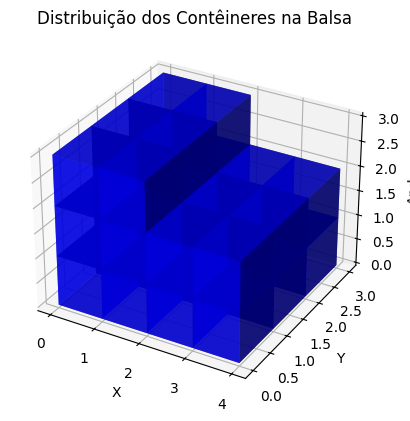

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualizar_balsa(df_cromossomo, titulo):
    # Inicializar a balsa
    balsa = np.zeros((3, 4, 3), dtype=int)
    
    # Preencher a balsa com os dados do cromossomo
    for _, linha in df_cromossomo.iterrows():
        pos_final = linha['Posição Final']
        andar, x, y = pos_final // 12, (pos_final % 12) // 3, (pos_final % 12) % 3
        balsa[andar, x, y] = 1
    
    # Visualizar a balsa
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(titulo)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Andar')

    for andar in range(3):
        for x in range(4):
            for y in range(3):
                if balsa[andar, x, y] == 1:
                    ax.bar3d(x, y, andar, 1, 1, 1, color='b', alpha=0.7)
    
    plt.show()

# Exemplo de uso
df_cromossomo = cromossomo_para_dataframe(melhor_cromossomo)
visualizar_balsa(df_cromossomo, "Distribuição dos Contêineres na Balsa")


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import os

def visualizar_balsa_animada(df_cromossomo, titulo, output_gif):
    # Inicializar a balsa
    balsa = np.zeros((3, 4, 3), dtype=int)
    
    # Criar uma pasta temporária para armazenar os frames
    if not os.path.exists('temp_frames'):
        os.makedirs('temp_frames')
    
    # Função auxiliar para salvar frames
    def salvar_frame(balsa, frame_num):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_title(f"{titulo} - Frame {frame_num}")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Andar')

        for andar in range(3):
            for x in range(4):
                for y in range(3):
                    if balsa[andar, x, y] == 1:
                        ax.bar3d(x, y, andar, 1, 1, 1, color='b', alpha=0.7)
        
        plt.savefig(f'temp_frames/frame_{frame_num}.png')
        plt.close()
    
    # Preencher a balsa com os dados do cromossomo e salvar frames
    for frame_num, (_, linha) in enumerate(df_cromossomo.iterrows()):
        pos_final = linha['Posição Final']
        if pos_final < 36:  # Garantir que a posição final esteja dentro dos limites da balsa
            andar, x, y = pos_final // 12, (pos_final % 12) // 3, (pos_final % 12) % 3
            balsa[andar, x, y] = 1
        salvar_frame(balsa, frame_num)
    
    # Criar o GIF
    with imageio.get_writer(output_gif, mode='I', duration=0.5) as writer:
        for frame_num in range(len(df_cromossomo)):
            frame_path = f'temp_frames/frame_{frame_num}.png'
            image = imageio.imread(frame_path)
            writer.append_data(image)
    
    # Remover frames temporários
    for frame_num in range(len(df_cromossomo)):
        os.remove(f'temp_frames/frame_{frame_num}.png')
    os.rmdir('temp_frames')

# Exemplo de uso
df_cromossomo = pd.DataFrame({
    'Posição Final': [0, 1, 14, 26, 32, 47, 55]  # Adicionei 55 para testar fora do limite
})

visualizar_balsa_animada(df_cromossomo, "Distribuição dos Contêineres na Balsa", "balsa_animada.gif")


C:\Users\berna\AppData\Local\Temp\ipykernel_27704\517663840.py:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_path)
